# 1. Download and Imports

In [2]:
# Fundamental classes
import numpy as np
import pandas as pd
import tensorflow as tf
import os

# Image related
import cv2
from PIL import Image

#Performance Plot
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For the model and it's training
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

# Time
import time
import datetime

# 2. Functions

In [3]:
# date_time function

def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:
        return 'Date today: %s' % datetime.date.today()

In [4]:
# Performance Plot

def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.figure(figsize=(20, 5))

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

# 3. Loading Dataset (Traffic Signs Images)

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


In [6]:
# Setting variables for later use
data = []
labels = []
classes = 43
cur_path = os.getcwd()

# Retrieving the images and their labels
for i in range(classes):
    path = os.path.join('../root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1','train',str(i))
    images = os.listdir(path)

    for a in images:
        try:
            image = Image.open(path + '/'+ a)
            image = image.resize((30,30))
            image = np.array(image)
            #sim = Image.fromarray(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")

# Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)

# 4. Data Splitting and conversion

In [7]:
# Checking data shape
print(data.shape, labels.shape)

# Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Displaying the shape after the split
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

(39209, 30, 30, 3) (39209,)
(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


# 5. Creating and Compiling the Model

In [8]:
from tensorflow.keras.callbacks import Callback

# Custom Callback to stop training at 96% accuracy
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= 0.96:
            print(f"\nAccuracy has reached 96% at epoch {epoch+1}. Stopping training...")
            self.model.stop_training = True
# Instantiate the callback
accuracy_callback = CustomCallback()

In [9]:
# Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.15))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.20))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(43, activation='softmax'))

# Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#M odel display
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 22, 22, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 9, 9, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 7, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,624,939 (6.20 MB)

 Trainable params: 1,624,939 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

# 6. Training the Model

In [10]:
with tf.device('/GPU:0'):
    epochs = 35
    history1 = model.fit(
        X_train,
        y_train,
        batch_size=128,
        epochs=epochs,
        validation_data=(X_test, y_test),
        callbacks=[accuracy_callback]  # Include the custom callback here
    )

Epoch 1/35
246/246 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - accuracy: 0.4570 - loss: 3.6166 - val_accuracy: 0.9348 - val_loss: 0.2777
Epoch 2/35
246/246 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.9240 - loss: 0.3099 - val_accuracy: 0.9847 - val_loss: 0.0699
Epoch 3/35
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - accuracy: 0.9698 - loss: 0.1155
Accuracy has reached 96% at epoch 3. Stopping training...
246/246 ━━━━━━━━━━━━━━━━━━━━ 253s 998ms/step - accuracy: 0.9698 - loss: 0.1154 - val_accuracy: 0.9901 - val_loss: 0.0459


# 7. Visualizing the performance of the Model during Training Phase

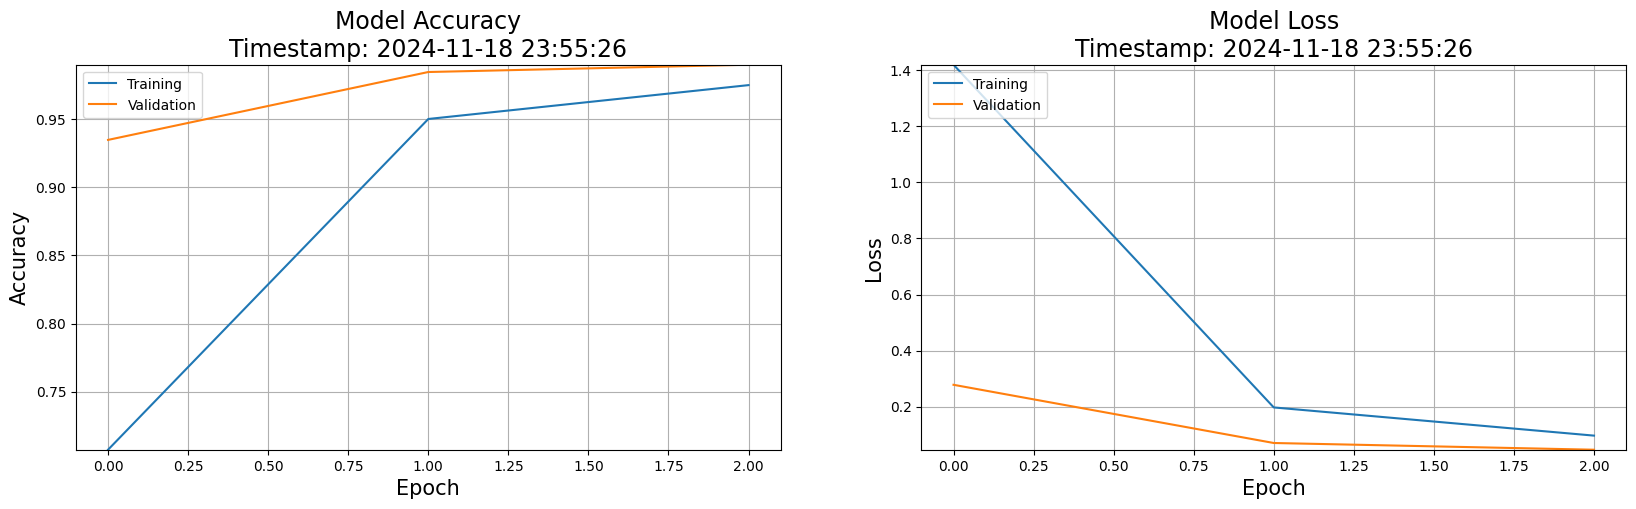

In [15]:
plot_performance(history=history1)

# 8. Loading Test Dataset and Evaluating the Model

In [16]:
# testing accuracy on test dataset
from sklearn.metrics import accuracy_score

# Importing the test dataset
y_test = pd.read_csv('/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/Test.csv')

labels = y_test["ClassId"].values
imgs = y_test["Path"].values

data=[]

# Retreiving the images
with tf.device('/GPU:0'):
    for img in imgs:
        image = Image.open('/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/'+img)
        image = image.resize([30, 30])
        data.append(np.array(image))

X_test=np.array(data)

In [17]:
with tf.device('/GPU:0'):
    pred = np.argmax(model.predict(X_test), axis=-1)

#Accuracy with the test data
from sklearn.metrics import accuracy_score
print(accuracy_score(labels, pred))

395/395 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step
0.9587490102929533


# 9. Saving the Model

In [20]:
# Save the model in SavedModel format
model.export('traffic_classifier_savedmodel')
print("Model successfully saved in SavedModel format at 'traffic_classifier_savedmodel'.")

Saved artifact at 'traffic_classifier_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 30, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 43), dtype=tf.float32, name=None)
Captures:
  137092438453136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137092438448208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137094997657024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137092438457184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137092438588256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137092438586496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137092438587200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137092439002624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137092439014944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137092439011600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13

In [21]:
# Convert to TF-Lite format
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model('traffic_classifier_savedmodel')
tflite_model = converter.convert()

# Save the TFLite model
with open('traffic_classifier.tflite', 'wb') as f:
    f.write(tflite_model)
print("Model successfully converted and saved as 'traffic_classifier.tflite'.")

Model successfully converted and saved as 'traffic_classifier.tflite'.


In [22]:
# Convert to TFJS format
import tensorflowjs as tfjs

tfjs_target_dir = 'traffic_classifier_tfjs'
tfjs.converters.convert_tf_saved_model('traffic_classifier_savedmodel', tfjs_target_dir)
print(f"Model successfully saved in TFJS format at '{tfjs_target_dir}'.")

Model successfully saved in TFJS format at 'traffic_classifier_tfjs'.
